In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch

%matplotlib inline

## Effect of member correctness on ensemble performance

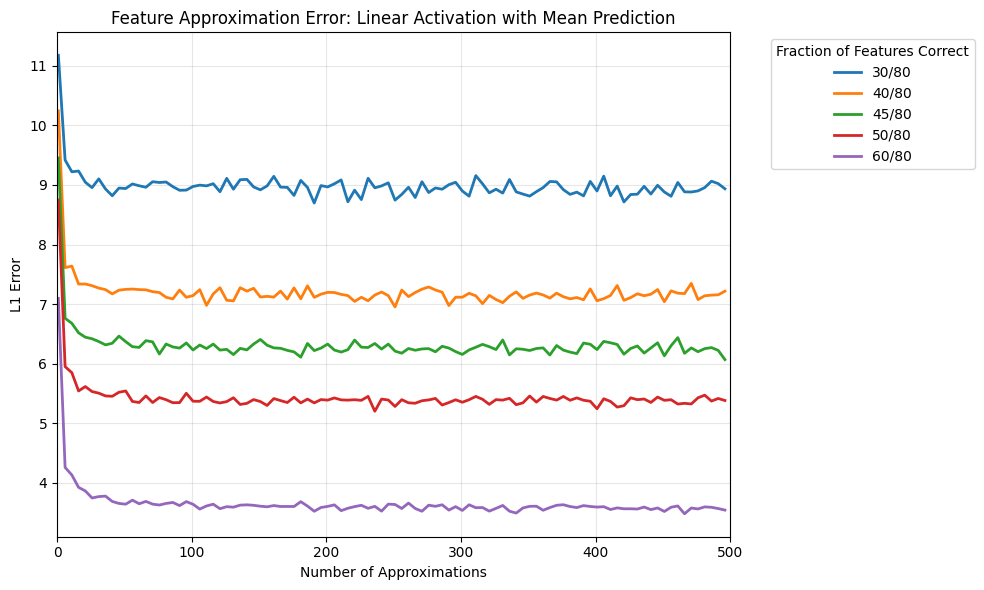

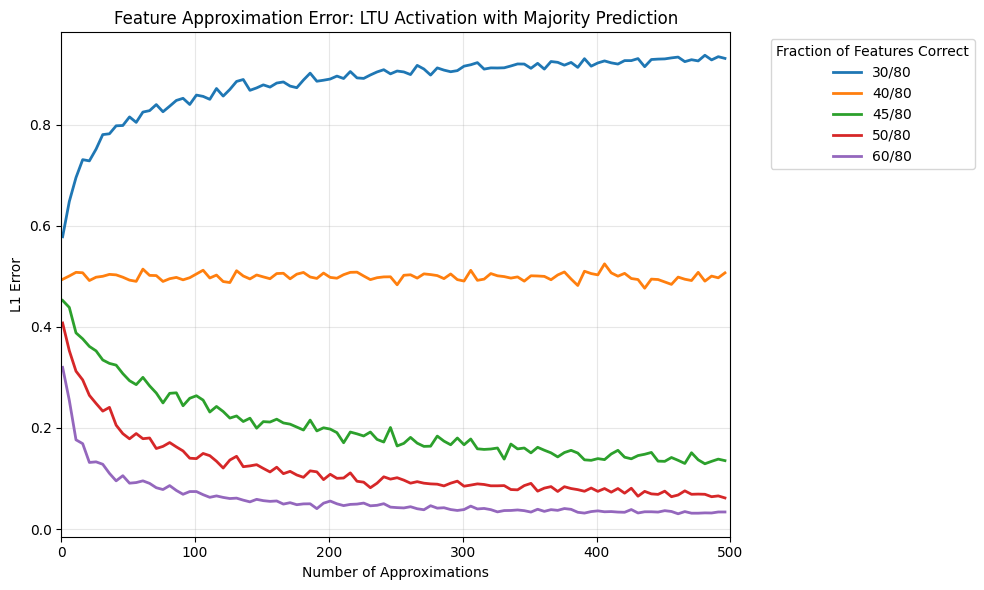

In [4]:
n_inputs = 80
n_correct_values = [30, 40, 45, 50, 60]
max_n_approximations = 500
n_approximations_list = list(range(1, max_n_approximations, 5))

target_weights = np.random.randint(0, 2, size=(n_inputs,)) * 2 - 1

ltu_activation_fn = lambda x: (x > 0).astype(float)
linear_activation_fn = lambda x: x

def run_approximation_experiment(activation_fn, prediction_type='mean', n_correct=65):
    prediction_errors_list = []
    for n_approximations in n_approximations_list:
        approx_weights = np.empty(shape=(n_approximations, n_inputs))

        for i in range(n_approximations):
            approx_weights[i, :] = target_weights[:]
            incorrect_idxs = np.random.choice(n_inputs, size=n_inputs - n_correct, replace=False)
            approx_weights[i, incorrect_idxs] = -approx_weights[i, incorrect_idxs]

        sample_inputs = np.random.randn(5000, n_inputs)

        real_outputs = activation_fn(sample_inputs @ target_weights).astype(float)
        approx_outputs = activation_fn(sample_inputs @ approx_weights.T).astype(float) # (n_samples, n_approximations)

        if prediction_type == 'mean':
            output_predictions = approx_outputs.mean(axis=1).astype(float)
        elif prediction_type == 'majority':
            output_predictions = (approx_outputs.mean(axis=1) >= 0.5).astype(float)

        prediction_errors = output_predictions - real_outputs
        l1_error = np.abs(prediction_errors).mean()
        
        prediction_errors_list.append(l1_error)
    
    return n_approximations_list, prediction_errors_list

# Run experiments for linear activation with mean prediction
linear_results_dict = {}
for n_correct in n_correct_values:
    linear_results_dict[n_correct] = run_approximation_experiment(
        linear_activation_fn, prediction_type='mean', n_correct=n_correct
    )

# Plot 1: Linear activation with mean prediction
plt.figure(figsize=(10, 6))
for n_correct in n_correct_values:
    fraction = f"{n_correct}/{n_inputs}"
    plt.plot(linear_results_dict[n_correct][0], linear_results_dict[n_correct][1], 
             label=fraction, linewidth=2)

plt.xlim(0, max_n_approximations)
plt.xlabel('Number of Approximations')
plt.ylabel('L1 Error')
plt.title('Feature Approximation Error: Linear Activation with Mean Prediction')
plt.legend(title='Fraction of Features Correct', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Run experiments for LTU activation with majority prediction
ltu_results_dict = {}
for n_correct in n_correct_values:
    ltu_results_dict[n_correct] = run_approximation_experiment(
        ltu_activation_fn, prediction_type='majority', n_correct=n_correct
    )

# Plot 2: LTU activation with majority prediction
plt.figure(figsize=(10, 6))
for n_correct in n_correct_values:
    fraction = f"{n_correct}/{n_inputs}"
    plt.plot(ltu_results_dict[n_correct][0], ltu_results_dict[n_correct][1], 
             label=fraction, linewidth=2)

plt.xlim(0, max_n_approximations)
plt.xlabel('Number of Approximations')
plt.ylabel('L1 Error')
plt.title('Feature Approximation Error: LTU Activation with Majority Prediction')
plt.legend(title='Fraction of Features Correct', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Test converting a continuous target into a cateegorical one

In [ ]:
def convert_values_to_binary(tensor, integer_precision=4, decimal_precision=10):
    tensor = tensor.clone()
    total_precision = integer_precision + decimal_precision
    binary_tensor = torch.zeros((tensor.shape[0], total_precision + 1))
    
    negative_mask = tensor < 0
    binary_tensor[:, 0] = negative_mask.to(torch.float)
    
    tensor = torch.abs(tensor)
    curr_precision = 2 ** (integer_precision - 1)
    for i in range(total_precision):
        ge = tensor >= curr_precision
        binary_tensor[:, i + 1] = ge.to(torch.float)
        tensor -= ge * curr_precision
        curr_precision /= 2.0
    
        
    return binary_tensor

def convert_binary_values_to_continuous(binary_tensor, integer_precision=4, decimal_precision=10):
    total_precision = integer_precision + decimal_precision
    
    # Extract sign bit (first column)
    negative_mask = binary_tensor[:, 0] > 0.5
    
    # Extract magnitude bits (remaining columns)
    magnitude_bits = binary_tensor[:, 1:]
    
    # Convert binary to decimal
    curr_precision = 2 ** (integer_precision - 1)
    continuous_values = torch.zeros(binary_tensor.shape[0])
    
    for i in range(total_precision):
        continuous_values += magnitude_bits[:, i] * curr_precision
        curr_precision /= 2.0
    
    # Apply sign
    continuous_values = torch.where(negative_mask, -continuous_values, continuous_values)
    
    return continuous_values

# convert_values_to_binary(torch.tensor([
#   0.1, 0.25, 0.4, 0.5, 0.75, 1.0, 2.0, 3.0
# ]), integer_precision=2, decimal_precision=4)

In [93]:
n_inputs = 80
n_correct_values = [40, 50, 60]
max_n_approximations = 300
n_outputs = 15
integer_precision = 4
decimal_precision = n_outputs - integer_precision - 1
n_approximations_list = list(range(1, max_n_approximations, max_n_approximations // 50))

ltu_activation_fn = lambda x: (x > 0).to(torch.float)
linear_activation_fn = lambda x: x

target_weights = (torch.rand(n_inputs) * 2 - 1) / torch.sqrt(torch.tensor(n_inputs))
train_inputs = torch.randn(100_000, n_inputs)
train_targets = linear_activation_fn(train_inputs @ target_weights)
binary_train_targets = convert_values_to_binary(
    train_targets, integer_precision, decimal_precision)

def run_approximation_experiment(n_approximations_list, n_correct=65):
    prediction_errors_list = []

    ideal_weights = torch.zeros(n_outputs, n_inputs, requires_grad=True)

    optimizer = torch.optim.Adam([ideal_weights], lr=0.1)
    criterion = torch.nn.BCEWithLogitsLoss()

    # Compute cross entropy loss between predictions and binary targets
    for i in range(300):
        predictions = train_inputs @ ideal_weights.T
        loss = criterion(predictions, binary_train_targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print(loss.item())
    
    # n_approximations_list = [10]
    for n_approximations in n_approximations_list:
        approx_weights = torch.empty(size=(n_approximations, n_outputs, n_inputs))
        
        for i in range(n_approximations):
            approx_weights[i, :, :] = ideal_weights[:, :]
            incorrect_idxs = torch.randperm(n_inputs)[:n_inputs - n_correct]
            approx_weights[i, :, incorrect_idxs] = -approx_weights[i, :, incorrect_idxs]

        sample_inputs = torch.randn(5000, n_inputs)

        real_outputs = sample_inputs @ target_weights # activation_fn(sample_inputs @ target_weights).to(torch.float) # (n_samples)
        approx_binary_outputs = ltu_activation_fn(sample_inputs @ approx_weights.transpose(1, 2)).to(torch.float) # (n_approximations, n_samples, n_outputs)
        approx_continuous_outputs = convert_binary_values_to_continuous(
            approx_binary_outputs.reshape(-1, n_outputs), integer_precision, decimal_precision)
        approx_continuous_outputs = approx_continuous_outputs.reshape(n_approximations, sample_inputs.shape[0])

        output_predictions = (approx_continuous_outputs.mean(dim=0) >= 0.5).to(torch.float)

        prediction_errors = output_predictions - real_outputs
        l1_error = torch.abs(prediction_errors).mean()
        
        prediction_errors_list.append(l1_error)
    
    return n_approximations_list, prediction_errors_list

0.6931473612785339
0.6498880982398987
0.6490663886070251
0.6931473612785339
0.6498880982398987
0.6490663886070251
0.6931473612785339
0.6498880982398987
0.6490663886070251


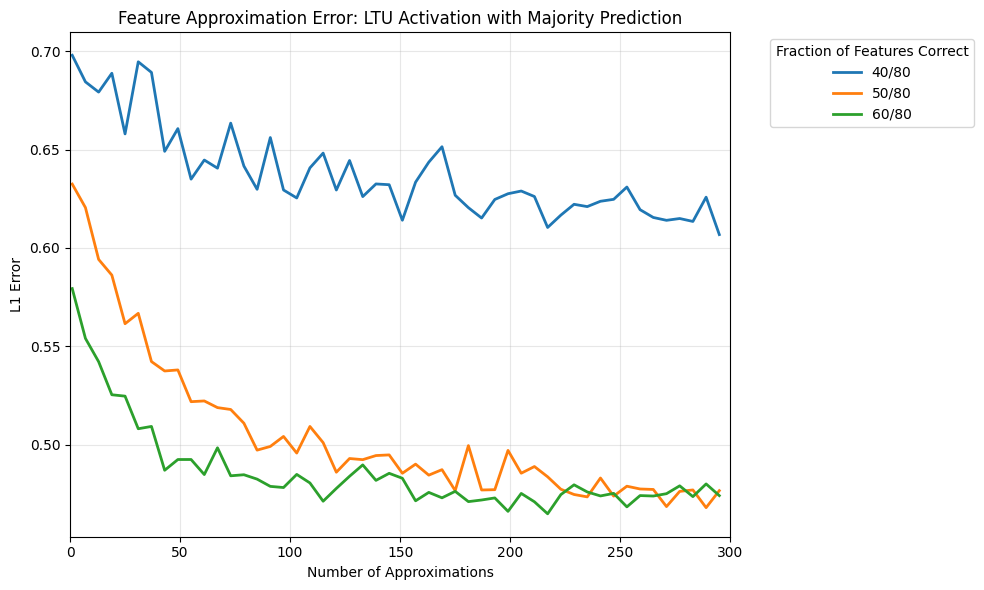

In [94]:
# Run experiments for LTU activation with majority prediction
ltu_results_dict = {}
for n_correct in n_correct_values:
    ltu_results_dict[n_correct] = run_approximation_experiment(
        n_approximations_list, n_correct=n_correct)

# Plot 2: LTU activation with majority prediction
plt.figure(figsize=(10, 6))
for n_correct in n_correct_values:
    fraction = f"{n_correct}/{n_inputs}"
    plt.plot(ltu_results_dict[n_correct][0], ltu_results_dict[n_correct][1], 
             label=fraction, linewidth=2)

plt.xlim(0, max_n_approximations)
plt.xlabel('Number of Approximations')
plt.ylabel('L1 Error')
plt.title('Feature Approximation Error: LTU Activation with Majority Prediction')
plt.legend(title='Fraction of Features Correct', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [87]:
run_approximation_experiment(
    ltu_activation_fn, 'majority', n_correct=n_correct)

0.6931473612785339
0.6498280763626099


([1,
  3,
  5,
  7,
  9,
  11,
  13,
  15,
  17,
  19,
  21,
  23,
  25,
  27,
  29,
  31,
  33,
  35,
  37,
  39,
  41,
  43,
  45,
  47,
  49,
  51,
  53,
  55,
  57,
  59,
  61,
  63,
  65,
  67,
  69,
  71,
  73,
  75,
  77,
  79,
  81,
  83,
  85,
  87,
  89,
  91,
  93,
  95,
  97,
  99],
 [tensor(0.5796),
  tensor(0.5537),
  tensor(0.5582),
  tensor(0.5594),
  tensor(0.5611),
  tensor(0.5555),
  tensor(0.5950),
  tensor(0.5736),
  tensor(0.5669),
  tensor(0.5794),
  tensor(0.5646),
  tensor(0.5807),
  tensor(0.5467),
  tensor(0.5430),
  tensor(0.5386),
  tensor(0.5319),
  tensor(0.5445),
  tensor(0.5477),
  tensor(0.5325),
  tensor(0.5394),
  tensor(0.5422),
  tensor(0.5462),
  tensor(0.5358),
  tensor(0.5331),
  tensor(0.5411),
  tensor(0.5236),
  tensor(0.5376),
  tensor(0.5254),
  tensor(0.5365),
  tensor(0.5371),
  tensor(0.5284),
  tensor(0.5364),
  tensor(0.5281),
  tensor(0.5193),
  tensor(0.5222),
  tensor(0.5147),
  tensor(0.5112),
  tensor(0.5187),
  tensor(0.5175),
  